In [ ]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels fbprophet tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("All libraries installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running set

In [ ]:
# Create sample sales data
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
products = ['Product_A', 'Product_B', 'Product_C']

# Generate sample data
data = []
for date in dates:
    for product in products:
        # Base sales with seasonality
        base_sales = 100 + 50 * np.sin(2 * np.pi * date.dayofyear / 365)

        # Weekend effect
        weekend_boost = 30 if date.weekday() >= 5 else 0

        # Random variation
        random_noise = np.random.normal(0, 20)

        # Holiday effect (random holidays)
        holiday_effect = 50 if np.random.random() < 0.02 else 0

        # Promotion effect (random promotions)
        promotion_effect = 40 if np.random.random() < 0.05 else 0

        sales = max(0, base_sales + weekend_boost + random_noise + holiday_effect + promotion_effect)

        data.append({
            'date': date,
            'product': product,
            'sales': sales,
            'is_weekend': 1 if date.weekday() >= 5 else 0,
            'is_holiday': 1 if holiday_effect > 0 else 0,
            'is_promotion': 1 if promotion_effect > 0 else 0,
            'month': date.month,
            'day_of_week': date.weekday()
        })

df = pd.DataFrame(data)
print("Sample data created successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Sample data created successfully!
Dataset shape: (4383, 8)

First 5 rows:
        date    product       sales  is_weekend  is_holiday  is_promotion  \
0 2020-01-01  Product_A  110.794951           0           0             0   
1 2020-01-01  Product_B   98.095382           0           0             0   
2 2020-01-01  Product_C  132.444924           0           0             0   
3 2020-01-02  Product_A  117.069775           0           0             0   
4 2020-01-02  Product_B   92.452727           0           0             0   

   month  day_of_week  
0      1            2  
1      1            2  
2      1            2  
3      1            3  
4      1            3  


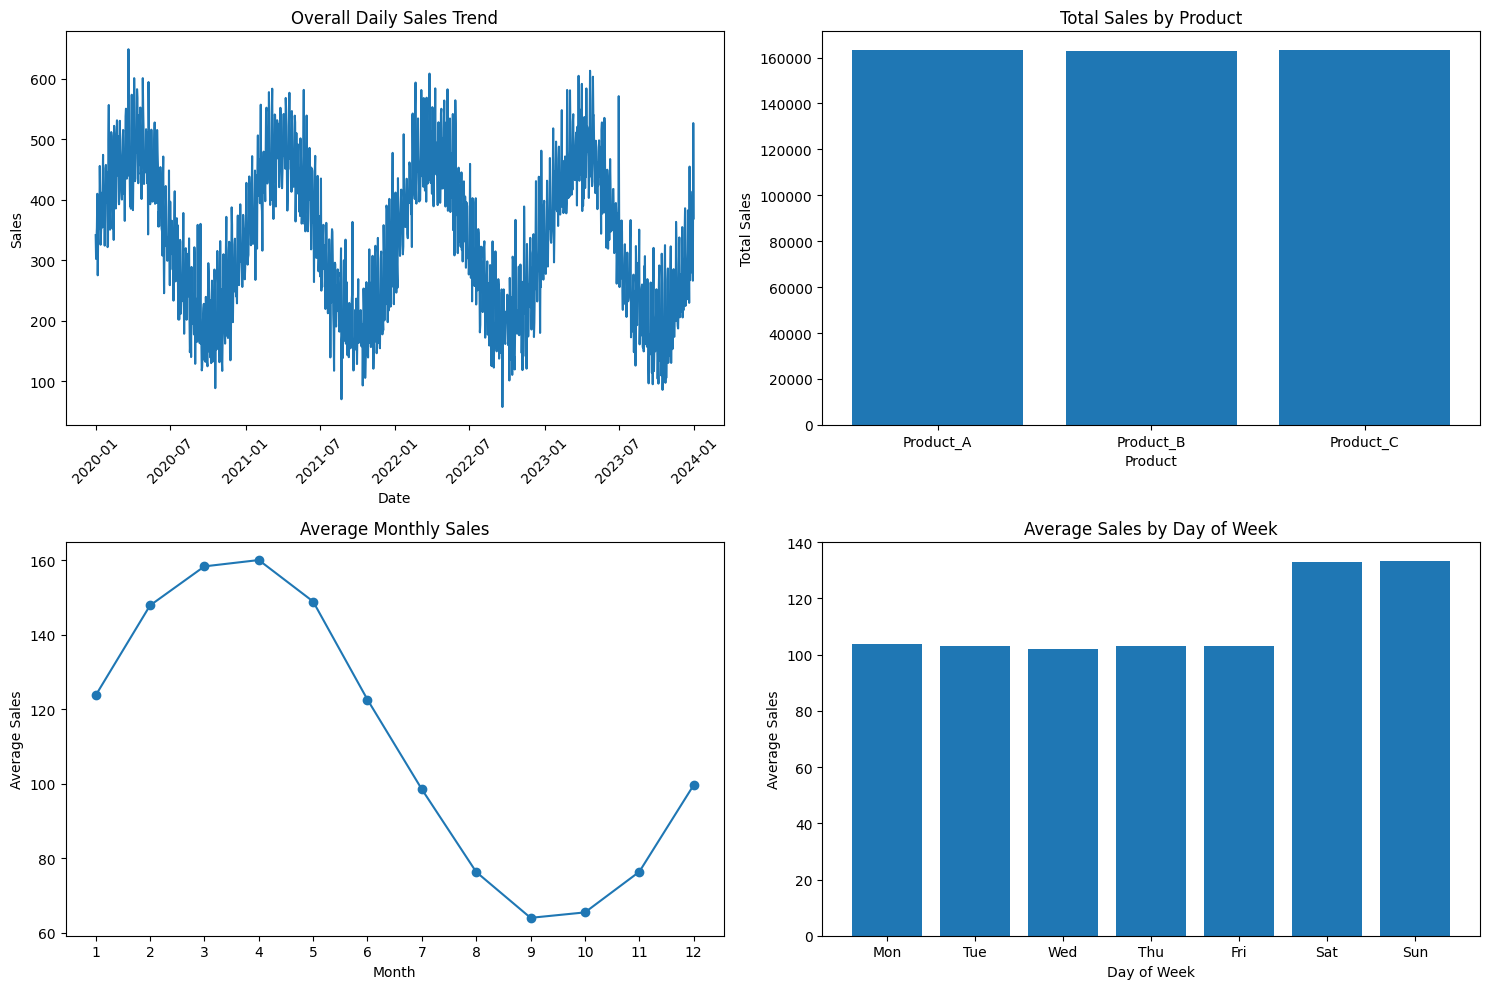

In [ ]:
# Plot sales trends
plt.figure(figsize=(15, 10))

# Plot 1: Overall sales trend
plt.subplot(2, 2, 1)
daily_sales = df.groupby('date')['sales'].sum()
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Overall Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)

# Plot 2: Sales by product
plt.subplot(2, 2, 2)
product_sales = df.groupby('product')['sales'].sum()
plt.bar(product_sales.index, product_sales.values)
plt.title('Total Sales by Product')
plt.xlabel('Product')
plt.ylabel('Total Sales')

# Plot 3: Monthly sales pattern
plt.subplot(2, 2, 3)
monthly_sales = df.groupby('month')['sales'].mean()
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))

# Plot 4: Day of week pattern
plt.subplot(2, 2, 4)
dow_sales = df.groupby('day_of_week')['sales'].mean()
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], dow_sales.values)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for time series forecasting
# Let's focus on one product for simplicity
product_a_data = df[df['product'] == 'Product_A'].copy()
product_a_data = product_a_data.set_index('date')[['sales']]
product_a_data = product_a_data.asfreq('D').fillna(method='ffill')

# Split data into train and test
split_date = '2023-06-01'
train_data = product_a_data[product_a_data.index < split_date]
test_data = product_a_data[product_a_data.index >= split_date]

print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")
print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

Training data: (1247, 1)
Test data: (214, 1)
Training period: 2020-01-01 00:00:00 to 2023-05-31 00:00:00
Test period: 2023-06-01 00:00:00 to 2023-12-31 00:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Check if data is stationary
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

print("Stationarity check for sales data:")
check_stationarity(train_data['sales'])

# If p-value > 0.05, data is not stationary, we need to difference
# Let's try ARIMA model
try:
    # Fit ARIMA model (you can adjust parameters)
    arima_model = ARIMA(train_data['sales'], order=(2,1,2))
    arima_fit = arima_model.fit()

    # Forecast
    arima_forecast = arima_fit.forecast(steps=len(test_data))

    # Calculate metrics
    arima_rmse = np.sqrt(mean_squared_error(test_data['sales'], arima_forecast))
    arima_mape = mean_absolute_percentage_error(test_data['sales'], arima_forecast) * 100

    print(f"ARIMA Model Results:")
    print(f"RMSE: {arima_rmse:.2f}")
    print(f"MAPE: {arima_mape:.2f}%")

except Exception as e:
    print(f"ARIMA model failed: {e}")
    # Use simple moving average as fallback
    arima_forecast = [train_data['sales'].rolling(window=7).mean().iloc[-1]] * len(test_data)
    arima_rmse = np.sqrt(mean_squared_error(test_data['sales'], arima_forecast))
    arima_mape = mean_absolute_percentage_error(test_data['sales'], arima_forecast) * 100
    print(f"Using fallback method - RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")

Stationarity check for sales data:
ADF Statistic: -1.5221129752633336
p-value: 0.5225453906569277
Critical Values:
   1%: -3.4357081998138064
   5%: -2.863906139614306
   10%: -2.568029768447359
ARIMA Model Results:
RMSE: 58.52
MAPE: 89.25%


In [ ]:
try:
    from fbprophet import Prophet

    # Prepare data for Prophet
    prophet_train = train_data.reset_index()
    prophet_train = prophet_train.rename(columns={'date': 'ds', 'sales': 'y'})

    # Create and fit model
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    prophet_model.fit(prophet_train)

    # Create future dataframe
    future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')

    # Forecast
    prophet_forecast = prophet_model.predict(future)
    prophet_forecast = prophet_forecast[prophet_forecast['ds'] >= test_data.index.min()]

    # Calculate metrics
    prophet_rmse = np.sqrt(mean_squared_error(test_data['sales'], prophet_forecast['yhat']))
    prophet_mape = mean_absolute_percentage_error(test_data['sales'], prophet_forecast['yhat']) * 100

    print(f"Prophet Model Results:")
    print(f"RMSE: {prophet_rmse:.2f}")
    print(f"MAPE: {prophet_mape:.2f}%")

    # Plot Prophet forecast
    prophet_model.plot(prophet_forecast)
    plt.title('Prophet Forecast')
    plt.show()

except Exception as e:
    print(f"Prophet model failed: {e}")
    prophet_rmse = None
    prophet_mape = None

Prophet model failed: No module named 'fbprophet'


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
LSTM Model Results:
RMSE: 26.81
MAPE: 26.09%


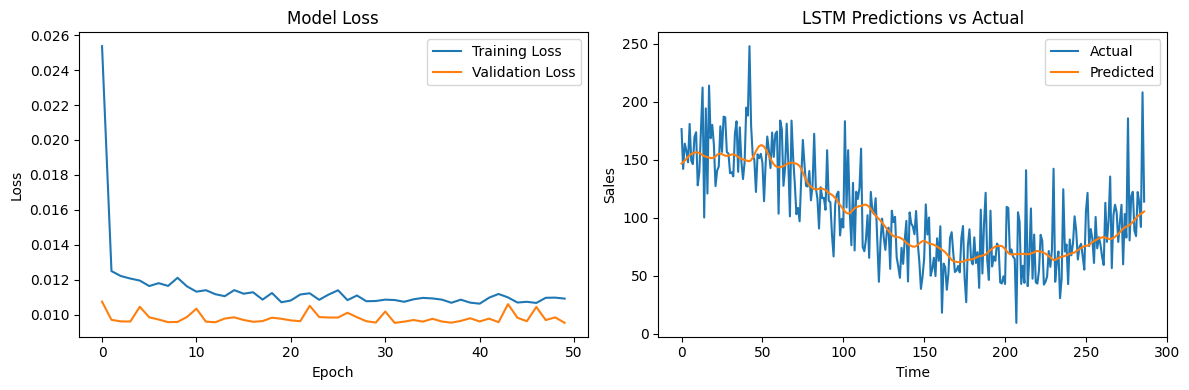

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(product_a_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Use 30 days to predict next day
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=0
)

# Make predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_predictions) * 100

print(f"LSTM Model Results:")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual')
plt.plot(lstm_predictions, label='Predicted')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

Model Comparison:
     Model       RMSE   MAPE (%)
0    ARIMA  58.517855  89.251325
1  Prophet        N/A        N/A
2     LSTM  26.814442  26.087937

Best performing model: LSTM


ValueError: x and y must have same first dimension, but have shapes (214,) and (287, 1)

<Figure size 1000x600 with 0 Axes>

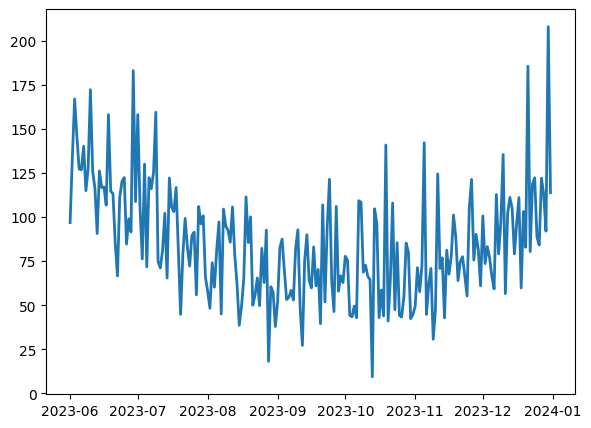

In [ ]:
# Create comparison table
results = {
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, prophet_rmse if prophet_rmse else 'N/A', lstm_rmse],
    'MAPE (%)': [arima_mape, prophet_mape if prophet_mape else 'N/A', lstm_mape]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)

# Visual comparison
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for the best model
best_model_idx = np.argmin([arima_rmse, prophet_rmse if prophet_rmse else float('inf'), lstm_rmse])
best_models = ['ARIMA', 'Prophet', 'LSTM']
best_model = best_models[best_model_idx]

print(f"\nBest performing model: {best_model}")

# Plot final results
plt.figure(figsize=(15, 5))

# Plot actual vs predicted
plt.subplot(1, 2, 1)
plt.plot(test_data.index, test_data['sales'], label='Actual', linewidth=2)

if best_model == 'ARIMA':
    plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
elif best_model == 'Prophet' and prophet_rmse:
    plt.plot(test_data.index, prophet_forecast['yhat'].values, label='Prophet Forecast', linestyle='--')
else:
    # For LSTM, we need to align the dates properly
    lstm_dates = test_data.index[:len(lstm_predictions)]
    plt.plot(lstm_dates, lstm_predictions, label='LSTM Forecast', linestyle='--')

plt.title(f'Actual vs {best_model} Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)

# Plot error distribution
plt.subplot(1, 2, 2)
if best_model == 'ARIMA':
    errors = test_data['sales'] - arima_forecast
elif best_model == 'Prophet' and prophet_rmse:
    errors = test_data['sales'] - prophet_forecast['yhat'].values
else:
    errors = y_test_actual.flatten() - lstm_predictions.flatten()

plt.hist(errors, bins=30, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Generate final report
print("="*60)
print("DEMAND FORECASTING PROJECT - FINAL REPORT")
print("="*60)

print(f"\nPROJECT SUMMARY:")
print(f"- Total data points: {len(df)}")
print(f"- Products analyzed: {df['product'].nunique()}")
print(f"- Time period: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"- Training period: {train_data.index.min().date()} to {train_data.index.max().date()}")
print(f"- Testing period: {test_data.index.min().date()} to {test_data.index.max().date()}")

print(f"\nMODEL PERFORMANCE SUMMARY:")
for i, row in results_df.iterrows():
    print(f"{row['Model']}: RMSE = {row['RMSE']}, MAPE = {row['MAPE (%)']}")

print(f"\nRECOMMENDATIONS:")
print("1. Use the best performing model for inventory planning")
print("2. Regularly update the model with new data")
print("3. Consider incorporating external factors like weather, economic indicators")
print("4. Monitor forecast accuracy and retrain model periodically")

print(f"\nNEXT STEPS:")
print("1. Try different model parameters to improve accuracy")
print("2. Add more features like marketing spend, competitor data")
print("3. Implement the model in a production environment")
print("4. Create automated reporting dashboards")

DEMAND FORECASTING PROJECT - FINAL REPORT

PROJECT SUMMARY:
- Total data points: 4383
- Products analyzed: 3
- Time period: 2020-01-01 to 2023-12-31
- Training period: 2020-01-01 to 2023-05-31
- Testing period: 2023-06-01 to 2023-12-31

MODEL PERFORMANCE SUMMARY:
ARIMA: RMSE = 58.51785488333296, MAPE = 89.2513253184082
Prophet: RMSE = N/A, MAPE = N/A
LSTM: RMSE = 26.814442312933394, MAPE = 26.087937319859876

RECOMMENDATIONS:
1. Use the best performing model for inventory planning
2. Regularly update the model with new data
3. Consider incorporating external factors like weather, economic indicators
4. Monitor forecast accuracy and retrain model periodically

NEXT STEPS:
1. Try different model parameters to improve accuracy
2. Add more features like marketing spend, competitor data
3. Implement the model in a production environment
4. Create automated reporting dashboards


In [ ]:
# Save the notebook
from google.colab import files

# Save results to CSV
results_df.to_csv('demand_forecasting_results.csv', index=False)

# Download the results
files.download('demand_forecasting_results.csv')

print("Results saved and downloaded successfully!")
print("Don't forget to save your Colab notebook: File -> Save")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results saved and downloaded successfully!
Don't forget to save your Colab notebook: File -> Save
